In [12]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from keras import regularizers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Conv1D, LSTM,MaxPooling1D, AveragePooling1D, Concatenate, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Concatenate, Input
from keras.utils.vis_utils import plot_model
import os
import re
import sys
print(sys.executable)
!{sys.executable} -m pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA

current_working = os.getcwd()
print(current_working)

/opt/anaconda3/envs/TF/bin/python
/Users/subarnasapkota/Water Quality/Burnettdataset


In [13]:
df = pd.read_csv('/Users/subarnasapkota/Water Quality//Burnettdataset/used_data2.csv')
df.columns
df.tail()
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.drop(columns=['Unnamed: 0','year', 'month','day_of_year',
       'week_of_year', 'quarter', 'season', 'month_sin','Chloraphylla ugL_seasonal','DO mg_seasonal','DO Sat_seasonal','EC mScm_seasonal',
                     'Turbidity NTU_seasonal','Temp degC_seasonal','pH_seasonal'])
df.columns

Index(['Timestamp', 'Chloraphylla ugL', 'DO mg', 'DO Sat', 'EC mScm', 'pH',
       'Temp degC', 'Turbidity NTU', 'day', 'month_cos',
       'Chloraphylla ugL_trend', 'DO mg_trend', 'DO Sat_trend',
       'EC mScm_trend', 'pH_trend', 'Temp degC_trend', 'Turbidity NTU_trend',
       'Chloraphylla ugL_residual', 'DO mg_residual', 'DO Sat_residual',
       'EC mScm_residual', 'pH_residual', 'Temp degC_residual',
       'Turbidity NTU_residual'],
      dtype='object')

In [14]:

target = 'DO mg'

In [15]:
df.tail()

,Timestamp,Chloraphylla ugL,DO mg,DO Sat,EC mScm,pH,Temp degC,Turbidity NTU,day,month_cos,...,pH_trend,Temp degC_trend,Turbidity NTU_trend,Chloraphylla ugL_residual,DO mg_residual,DO Sat_residual,EC mScm_residual,pH_residual,Temp degC_residual,Turbidity NTU_residual
3259,2021-12-04,9.992222,6.05750,73.345611,0.934111,7.008278,24.904167,112.159000,4,1.0,...,7.324856,28.644403,26.271595,-16.440756,0.935349,-0.692373,-31.565572,-0.293531,-3.651961,83.685580
3260,2021-12-05,9.992222,6.05750,73.345611,0.934111,7.008278,24.904167,112.159000,5,1.0,...,7.319544,28.720318,26.626144,-16.779475,0.938321,-0.639596,-31.246884,-0.285897,-3.716755,83.039427
3261,2021-12-06,10.119500,6.07660,73.703550,0.899950,7.075075,24.994675,113.940875,6,1.0,...,7.314233,28.796234,26.980693,-16.983555,0.961983,-0.214532,-30.964094,-0.213393,-3.696587,84.279844
3262,2021-12-07,10.265278,6.10150,74.145764,0.864339,7.154972,25.094383,116.190250,7,1.0,...,7.308922,28.872150,27.335242,-17.153322,0.992523,0.317111,-30.712267,-0.129306,-3.667120,86.077158
3263,2021-12-08,10.498556,6.13794,74.813273,0.822748,7.262644,25.252457,119.968090,8,1.0,...,7.303610,28.948065,27.689791,-17.217293,1.038739,1.137818,-30.491634,-0.017904,-3.570964,89.359177


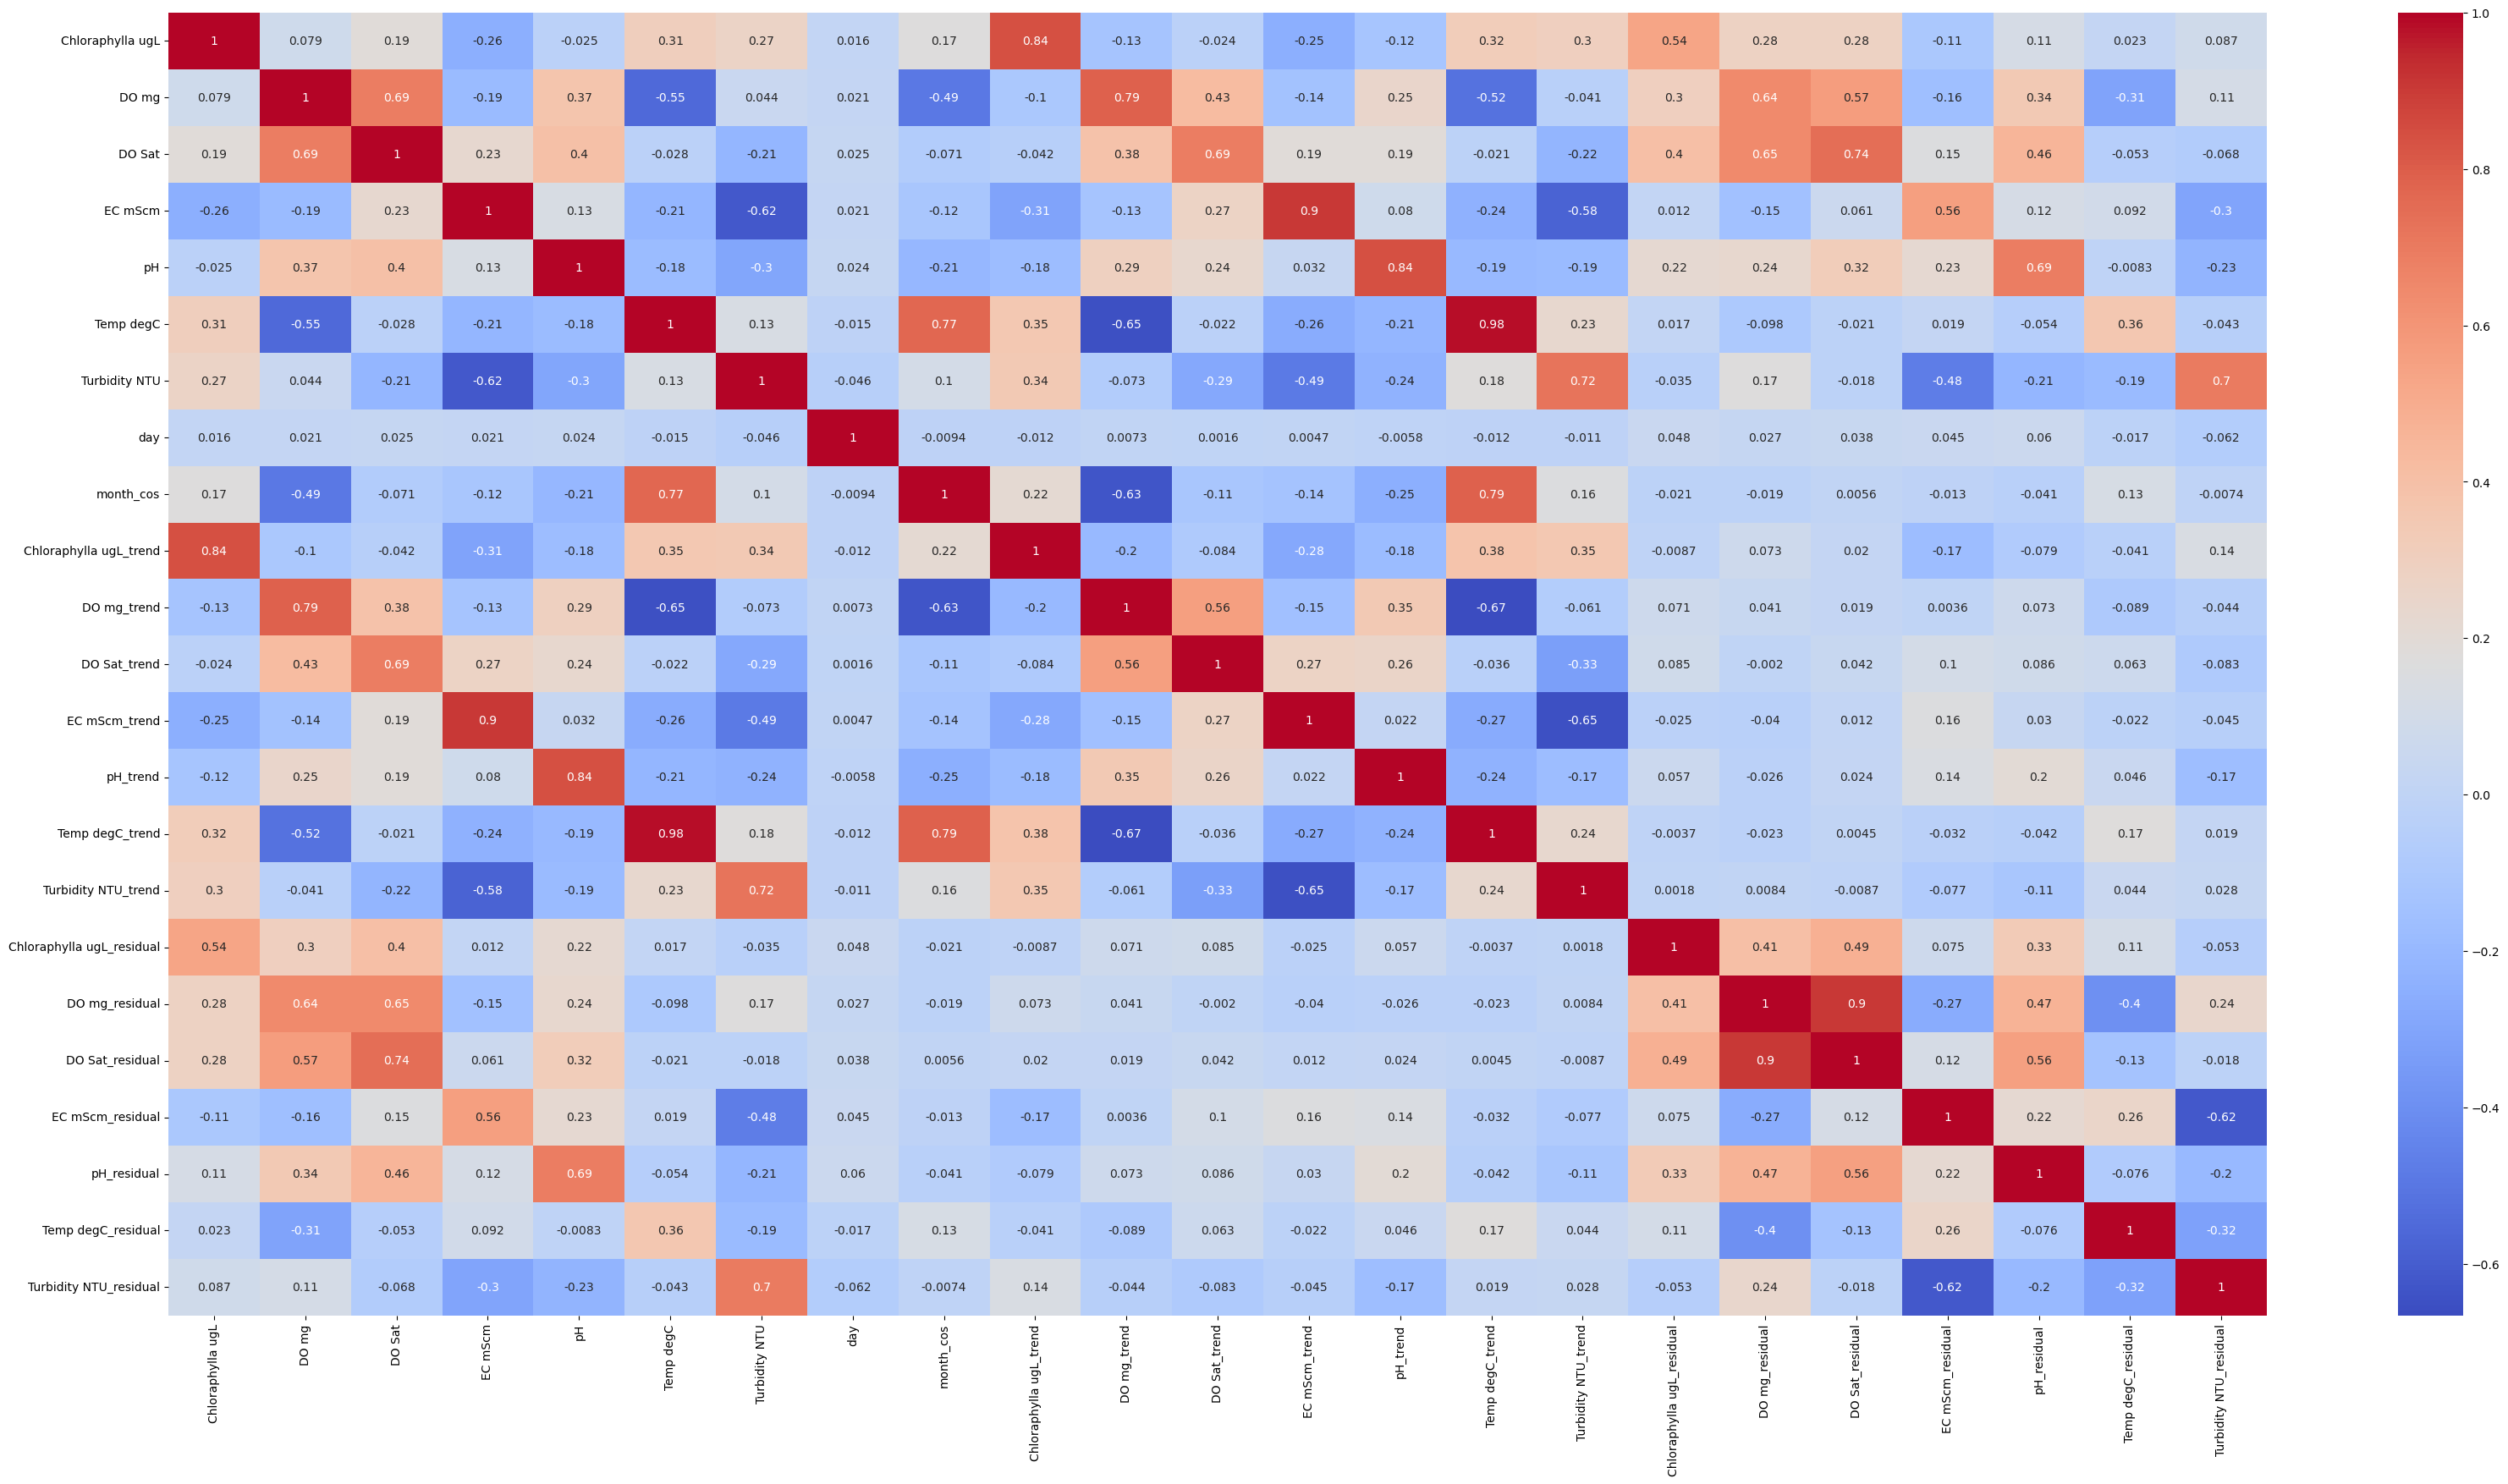

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'timestamp' is the column you want to exclude
df_filtered = df.drop(columns=['Timestamp'])

# Calculate the correlation matrix
corr_matrix = df_filtered.corr()

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(40, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()
corr_matrix.to_csv("correlation_matrix.csv")

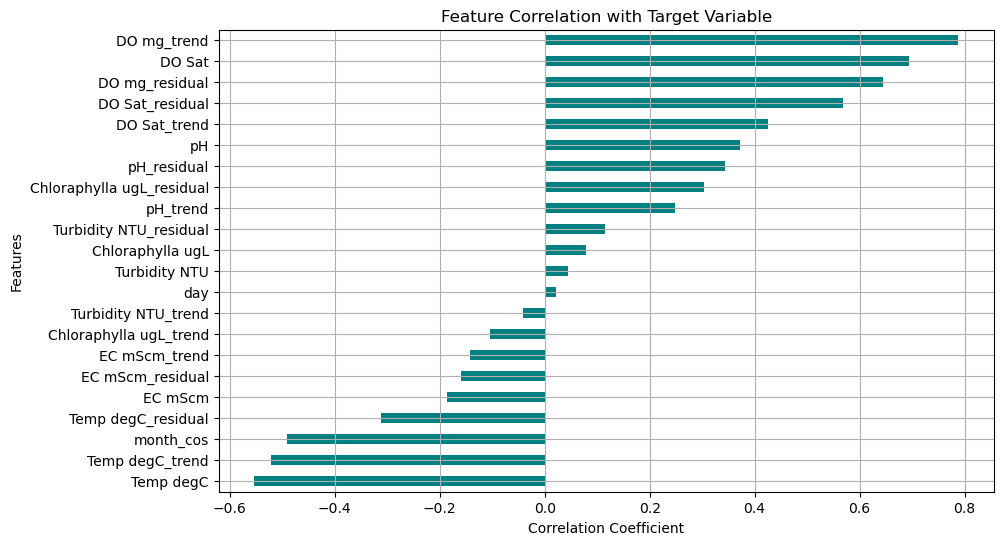

Selected features based on correlation with target: ['DO Sat', 'EC mScm', 'pH', 'Temp degC', 'month_cos', 'Chloraphylla ugL_trend', 'DO mg_trend', 'DO Sat_trend', 'EC mScm_trend', 'pH_trend', 'Temp degC_trend', 'Chloraphylla ugL_residual', 'DO mg_residual', 'DO Sat_residual', 'EC mScm_residual', 'pH_residual', 'Temp degC_residual', 'Turbidity NTU_residual']
Highly correlated feature pairs (above threshold): [('EC mScm_trend', 'EC mScm'), ('pH_trend', 'pH'), ('Temp degC_trend', 'Temp degC'), ('DO Sat_residual', 'DO mg_residual')]
Final selected features after removing multicollinearity: ['DO Sat', 'month_cos', 'Chloraphylla ugL_trend', 'DO mg_trend', 'DO Sat_trend', 'EC mScm_trend', 'pH_trend', 'Temp degC_trend', 'Chloraphylla ugL_residual', 'DO Sat_residual', 'EC mScm_residual', 'pH_residual', 'Temp degC_residual', 'Turbidity NTU_residual']


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and 'target' is your target variable name

# Step 1: Calculate the Pearson correlation matrix
correlation_matrix = df_filtered.corr()

# Step 2: Correlation of features with the target variable
target_correlation = correlation_matrix[target].drop(target)  # Drop self-correlation

# Step 3: Visualize correlation with the target
plt.figure(figsize=(10, 6))
target_correlation.sort_values().plot(kind='barh', color='teal')
plt.title('Feature Correlation with Target Variable')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(True)
plt.show()

# Step 4: Select features with a strong correlation with the target variable
threshold = 0.1  # Set your threshold (e.g., 0.1 for correlation > |0.1|)
selected_features = target_correlation[abs(target_correlation) > threshold].index.tolist()

print("Selected features based on correlation with target:", selected_features)

# Step 5: Removing multicollinearity (optional)
# Calculate correlations between selected features
selected_corr_matrix = df[selected_features].corr()

# Set threshold for high multicollinearity
multicollinearity_threshold = 0.8

# Identify and remove one of the highly correlated features
high_corr_pairs = []
for i in range(len(selected_corr_matrix.columns)):
    for j in range(i):
        if abs(selected_corr_matrix.iloc[i, j]) > multicollinearity_threshold:
            high_corr_pairs.append((selected_corr_matrix.columns[i], selected_corr_matrix.columns[j]))

print("Highly correlated feature pairs (above threshold):", high_corr_pairs)

# Remove one feature from each highly correlated pair (optional step)
features_to_remove = {pair[1] for pair in high_corr_pairs}  # Keep the first feature
final_features = [feature for feature in selected_features if feature not in features_to_remove]

print("Final selected features after removing multicollinearity:", final_features)

# Use final_features for your modeling
selected_data = df[final_features]


##**Split the data into training and testing**

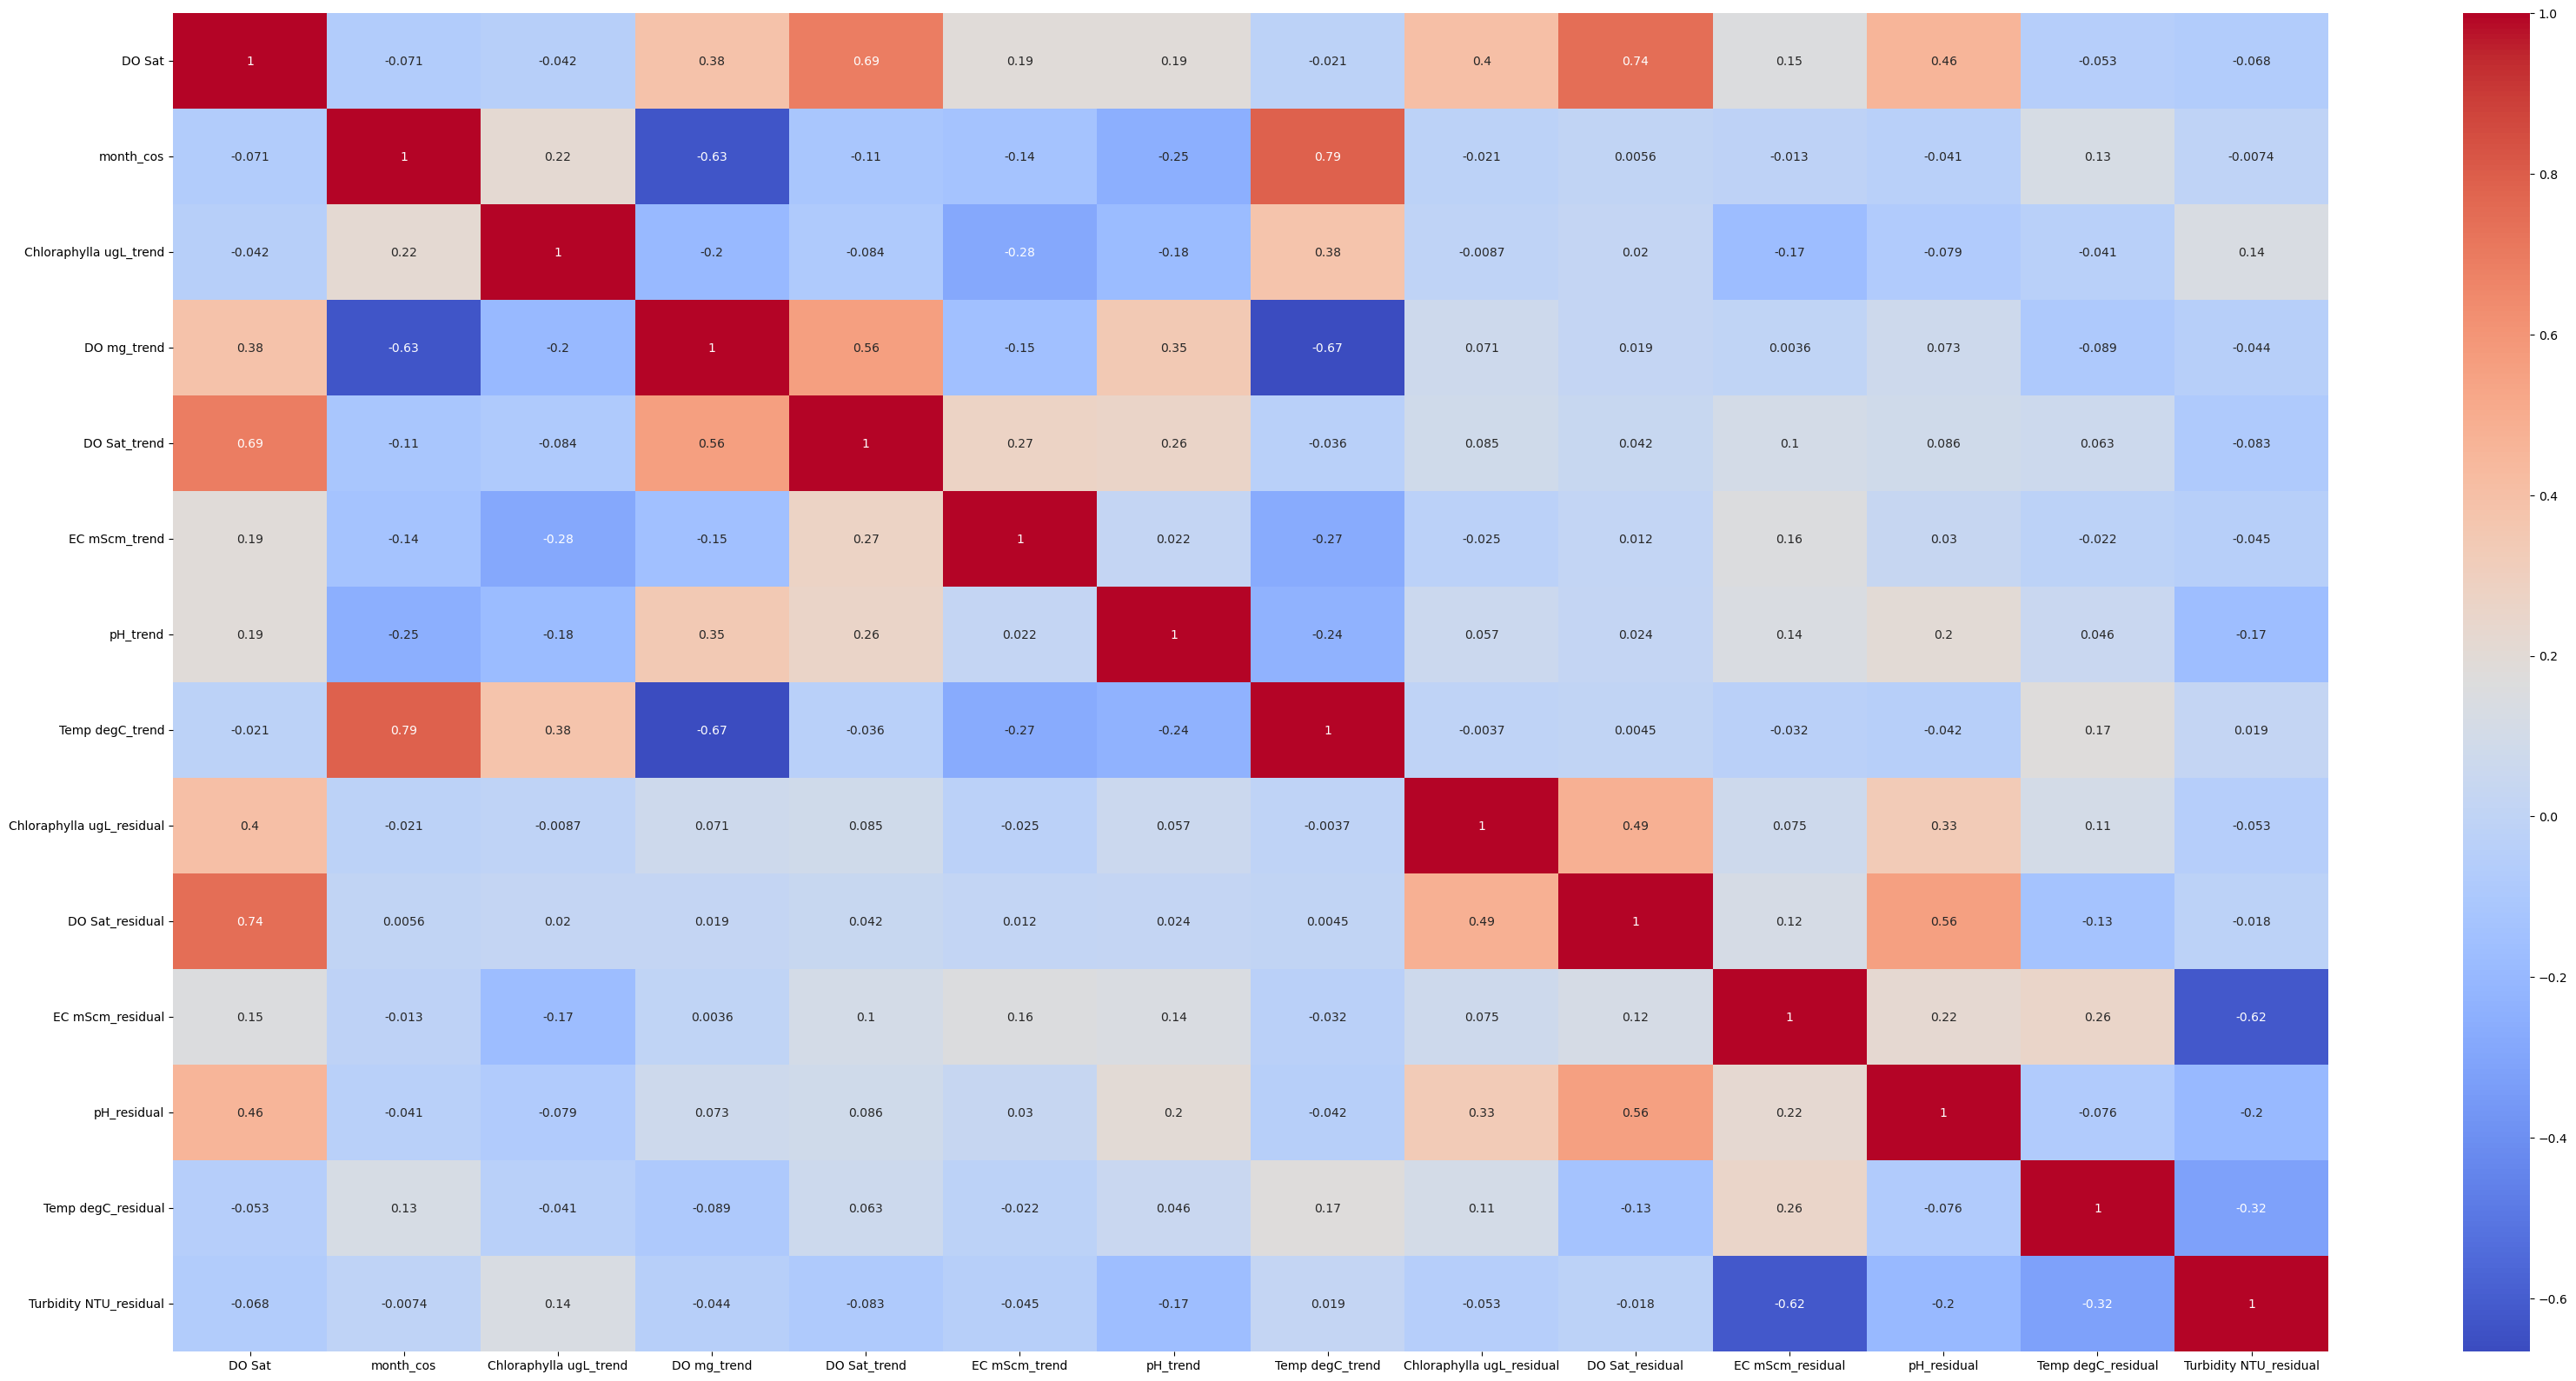

In [18]:
# Specify the desired columns you want to include
"""columns_to_include = ['Chloraphylla ugL_trend','DO Sat_trend', 
    'EC mScm_trend', 'pH_trend', 'Temp degC_trend', 
    'Chloraphylla ugL_residual',
    'pH_residual', 'Temp degC_residual', 'Turbidity NTU_residual']"""

columns_to_include = ['DO Sat', 'month_cos', 'Chloraphylla ugL_trend','DO mg_trend', 'DO Sat_trend', 'EC mScm_trend', 'pH_trend', 'Temp degC_trend', 'Chloraphylla ugL_residual', 
                     'DO Sat_residual', 'EC mScm_residual', 'pH_residual', 'Temp degC_residual', 'Turbidity NTU_residual']

# Filter the DataFrame to include only these columns
df_filtered = df[columns_to_include]
# Calculate the correlation matrix
corr_matrix = df_filtered.corr()

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(40, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()
corr_matrix.to_csv("correlation_matrix.csv")

In [19]:
# Select relevant columns ( Remove column= Do sat, Month_cos, Do sat residual)
features = [['DO Sat', 'month_cos', 'Chloraphylla ugL_trend','DO mg_trend', 'DO Sat_trend', 'EC mScm_trend', 'pH_trend', 'Temp degC_trend', 'Chloraphylla ugL_residual', 
                     'DO Sat_residual', 'EC mScm_residual', 'pH_residual', 'Temp degC_residual', 'Turbidity NTU_residual']]  
target = 'DO mg'
df.info()

# Step 1: Decomposition into trend and residual (for target only)
decomposition = seasonal_decompose(df[target], model='additive', period=24)
df['Trend'] = decomposition.trend
df['Residual'] = decomposition.resid

# Fill NaN values from decomposition
df['Trend'] = df['Trend'].fillna(method='bfill').fillna(method='ffill')
df['Residual'] = df['Residual'].fillna(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3264 entries, 0 to 3263
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Timestamp                  3264 non-null   datetime64[ns]
 1   Chloraphylla ugL           3264 non-null   float64       
 2   DO mg                      3264 non-null   float64       
 3   DO Sat                     3264 non-null   float64       
 4   EC mScm                    3264 non-null   float64       
 5   pH                         3264 non-null   float64       
 6   Temp degC                  3264 non-null   float64       
 7   Turbidity NTU              3264 non-null   float64       
 8   day                        3264 non-null   int64         
 9   month_cos                  3264 non-null   float64       
 10  Chloraphylla ugL_trend     3264 non-null   float64       
 11  DO mg_trend                3264 non-null   float64       
 12  DO Sat

/var/folders/ln/8__rmtxn0m318w9qk4_j9xq00000gn/T/ipykernel_4940/3737216236.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Trend'] = df['Trend'].fillna(method='bfill').fillna(method='ffill')


In [20]:
# Step 2: Normalize data (excluding Timestamp)
scaler = MinMaxScaler()

# Select only numeric columns for normalization
numeric_columns = df.select_dtypes(include=[np.number]).columns
normalized_data = scaler.fit_transform(df[numeric_columns])
"""# Convert back to a DataFrame to maintain structure (optional)
normalized_df = pd.DataFrame(normalized_data, columns=numeric_columns, index=df.index)"""

'# Convert back to a DataFrame to maintain structure (optional)\nnormalized_df = pd.DataFrame(normalized_data, columns=numeric_columns, index=df.index)'

In [21]:

def create_sliding_window(data, target_col_idx, window_size=7, predict_days=7):
    X, y = [], []
    for i in range(len(data) - window_size - predict_days + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_days, target_col_idx])
    return np.array(X), np.array(y)

# Target column index for 'DO mg' in normalized data
target_col_idx = list(numeric_columns).index(target)
window_size = 7      # Past 7 days
predict_days = 7    # Predict next 7 days

X, y = create_sliding_window(normalized_data, target_col_idx, window_size, predict_days)


In [22]:
# Step 4: Train-test split
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

val = round(0.8*X_train.shape[0])
X_train,X_val,y_train,y_val = X_train[0:val],X_train[val+1 : -1],y_train[0:val],y_train[val + 1 : -1]



## TCN Model ##

Epoch 1/40


2025-03-08 14:41:35.232729: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


65/65 [==============================] - 1s 11ms/step - loss: 0.0262 - mae: 0.0874 - val_loss: 0.0220 - val_mae: 0.0809
Epoch 2/40
65/65 [==============================] - 1s 10ms/step - loss: 0.0178 - mae: 0.0590 - val_loss: 0.0171 - val_mae: 0.0626
Epoch 3/40
65/65 [==============================] - 1s 11ms/step - loss: 0.0155 - mae: 0.0526 - val_loss: 0.0146 - val_mae: 0.0541
Epoch 4/40
65/65 [==============================] - 1s 12ms/step - loss: 0.0135 - mae: 0.0466 - val_loss: 0.0128 - val_mae: 0.0478
Epoch 5/40
65/65 [==============================] - 1s 12ms/step - loss: 0.0124 - mae: 0.0440 - val_loss: 0.0109 - val_mae: 0.0422
Epoch 6/40
65/65 [==============================] - 1s 13ms/step - loss: 0.0115 - mae: 0.0419 - val_loss: 0.0098 - val_mae: 0.0353
Epoch 7/40
65/65 [==============================] - 1s 11ms/step - loss: 0.0108 - mae: 0.0404 - val_loss: 0.0087 - val_mae: 0.0259
Epoch 8/40
65/65 [==============================] - 1s 11ms/step - loss: 0.0102 - mae: 0.0388 

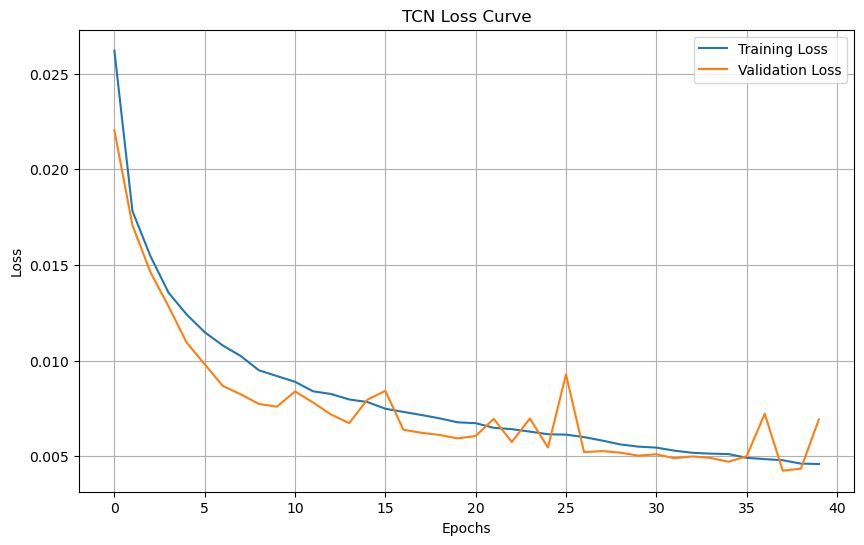

In [23]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Input, BatchNormalization, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Configuration for TCN parameters
tcn_config = {
    'filters': 128,
    'kernel_size': 5,
    'dropout_rate': 0.02,
    'l2_reg': 0.000013,
    'learning_rate': 0.00012,
    'batch_size': 32,
    'epochs': 40,

}

# Function to create a TCN block
def tcn_block(inputs, filters, kernel_size, dilation_rate, dropout_rate, l2_reg, activation):
    
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, kernel_regularizer=l2(l2_reg))(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dropout_rate)(x)

    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dropout_rate)(x)

    # Residual connection
    res = Conv1D(filters, 1, padding='same')(inputs)
    x = Add()([x, res])
    return x

# Build the TCN model
def build_tcn_model(input_shape, predict_days, config):
    
    inputs = Input(shape=input_shape)
    x = tcn_block(inputs, config['filters'], config['kernel_size'], 1, config['dropout_rate'], config['l2_reg'], activation='sigmoid')
    x = tcn_block(x, config['filters'], config['kernel_size'], 2, config['dropout_rate'], config['l2_reg'], activation='sigmoid')
    x = tcn_block(x, config['filters'], config['kernel_size'], 4, config['dropout_rate'], config['l2_reg'], activation='sigmoid')
    x = tcn_block(x, config['filters'], config['kernel_size'], 8, config['dropout_rate'], config['l2_reg'], activation='sigmoid')

    x = Flatten()(x)
    x = Dense(32, activation='sigmoid', kernel_regularizer=l2(config['l2_reg']))(x)
    output = Dense(predict_days, activation='sigmoid')(x)  
    model = Model(inputs=inputs, outputs=output)
    
    
    optimizer = Adam(learning_rate=config['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Prepare data shapes
input_shape = (X_train.shape[1], X_train.shape[2])
predict_days = y_train.shape[1]

# Build the TCN model
model_tcn = build_tcn_model(input_shape, predict_days, tcn_config)

# Create model directory if it doesn't exist
model_dir = 'Trainedmodels'
os.makedirs(model_dir, exist_ok=True)

# Train the model with early stopping
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history_tcn = model_tcn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=tcn_config['epochs'],
    batch_size=tcn_config['batch_size'],
 #   callbacks=[early_stopping]
)

# Save the model
model_path = os.path.join(model_dir, 'tcn_modelnew12.h5')
model_tcn.save(model_path)
print(f"Model saved to: {model_path}")

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(history_tcn.history['loss'], label='Training Loss')
plt.plot(history_tcn.history['val_loss'], label='Validation Loss')
plt.title('TCN Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
 


In [8]:
# Predict on Training and Validation sets
y_train_pred = model_tcn.predict(X_train)
y_val_pred = model_tcn.predict(X_val)

# Create a time axis for visualization
time_train = np.arange(len(y_train))
time_val = np.arange(len(y_train), len(y_train) + len(y_val))

# Plot Actual vs. Predicted values for Training and Validation sets
plt.figure(figsize=(12, 6))

plt.plot(time_train, y_train.flatten(), label="Actual Train", color='blue')
plt.plot(time_train, y_train_pred.flatten(), label="Predicted Train", linestyle="dashed", color='cyan')

plt.plot(time_val, y_val.flatten(), label="Actual Validation", color='red')
plt.plot(time_val, y_val_pred.flatten(), label="Predicted Validation", linestyle="dashed", color='orange')

plt.xlabel("Time Steps")
plt.ylabel("DO mg")
plt.title("Actual vs Predicted Values (Train & Validation)")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'model_tcn' is not defined

21/21 [==============================] - 0s 3ms/step
Day 1:
  MAE  = 0.0592
  RMSE = 0.0837
  R²   = 0.9868
  NSE  = 0.9868
Day 2:
  MAE  = 0.0677
  RMSE = 0.0911
  R²   = 0.9844
  NSE  = 0.9844
Day 3:
  MAE  = 0.0763
  RMSE = 0.1070
  R²   = 0.9785
  NSE  = 0.9785
Day 4:
  MAE  = 0.0848
  RMSE = 0.1194
  R²   = 0.9732
  NSE  = 0.9732
Day 5:
  MAE  = 0.0834
  RMSE = 0.1098
  R²   = 0.9774
  NSE  = 0.9774
Day 6:
  MAE  = 0.0873
  RMSE = 0.1202
  R²   = 0.9729
  NSE  = 0.9729
Day 7:
  MAE  = 0.0881
  RMSE = 0.1156
  R²   = 0.9750
  NSE  = 0.9750

Summary Metrics Across All Days:
Average MAE  = 0.0781
Average RMSE = 0.1067
Average R²   = 0.9783
Average NSE  = 0.9783


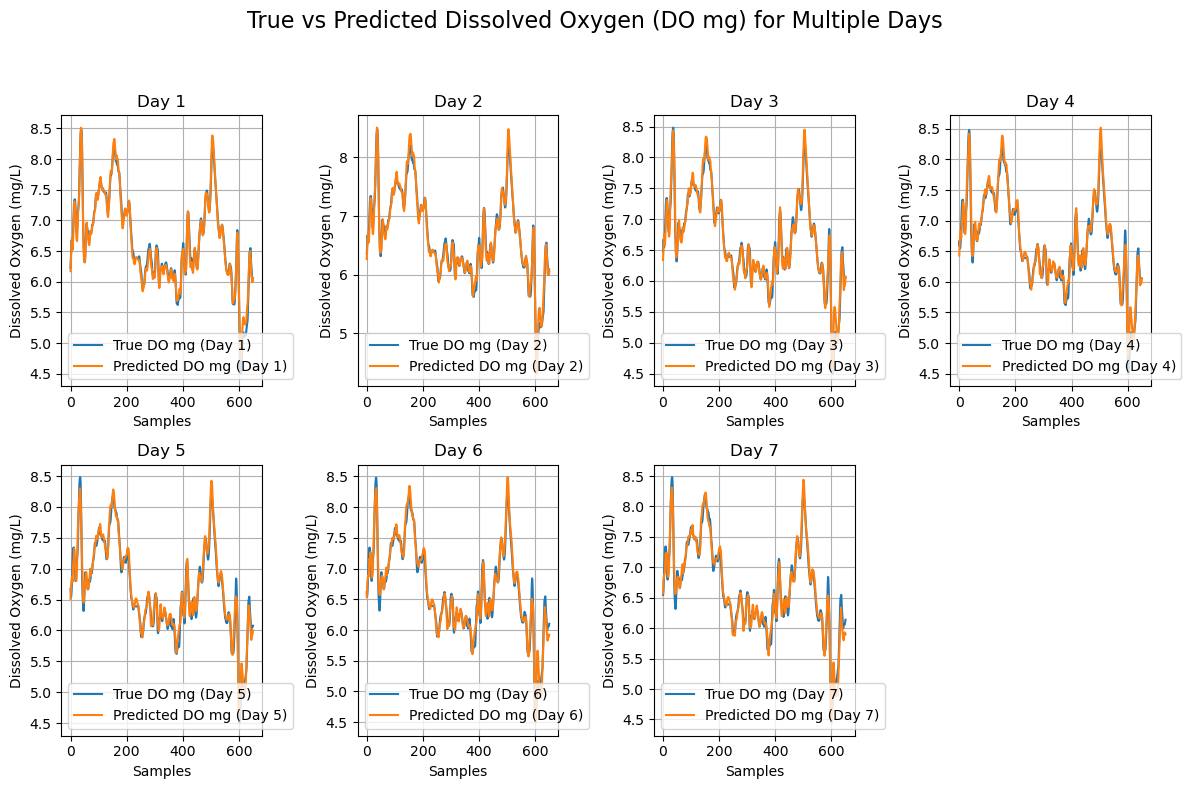

In [47]:
# Later, load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('Trainedmodels/tcn_model12.h5')
# Step 7: Evaluate the model
y_pred = loaded_model.predict(X_test)

# Step 8: Rescale predictions and test values back to the original scale
# Create dummy arrays with the same shape as normalized_data
dummy_test = np.zeros((y_test.shape[0] * predict_days, normalized_data.shape[1]))
dummy_pred = np.zeros((y_pred.shape[0] * predict_days, normalized_data.shape[1]))

# Fill only the target column with y_test and y_pred values
dummy_test[:, target_col_idx] = y_test.flatten()
dummy_pred[:, target_col_idx] = y_pred.flatten()

# Perform inverse scaling
y_test_original = scaler.inverse_transform(dummy_test)[:, target_col_idx].reshape(-1, predict_days)
y_pred_original = scaler.inverse_transform(dummy_pred)[:, target_col_idx].reshape(-1, predict_days)

from sklearn.metrics import r2_score

# Define a function for Nash-Sutcliffe Efficiency (NSE)
def nse(observed, predicted):
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (numerator / denominator)

# Step 9: Metrics for each prediction day
maes = []
rmses = []
mpes = []
r2s = []
nses = []

for day in range(predict_days):
    observed = y_test_original[:, day]
    predicted = y_pred_original[:, day]
    
    # Calculate metrics
    mae = mean_absolute_error(observed, predicted)
    rmse = np.sqrt(mean_squared_error(observed, predicted))
    mpe = np.mean((observed - predicted) / observed) * 100
    r2 = r2_score(observed, predicted)
    nse_val = nse(observed, predicted)
    
    # Append to respective lists
    maes.append(mae)
    rmses.append(rmse)
    mpes.append(mpe)
    r2s.append(r2)
    nses.append(nse_val)
    
    # Print metrics for the current day
    print(f"Day {day + 1}:")
    print(f"  MAE  = {mae:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  R²   = {r2:.4f}")
    print(f"  NSE  = {nse_val:.4f}")

# Optionally, summarize metrics across all days
print("\nSummary Metrics Across All Days:")
print(f"Average MAE  = {np.mean(maes):.4f}")
print(f"Average RMSE = {np.mean(rmses):.4f}")
print(f"Average R²   = {np.mean(r2s):.4f}")
print(f"Average NSE  = {np.mean(nses):.4f}")
# Step 10: Plot the results for all days (using rows and columns in a single figure)
import math

# Define the grid layout (e.g., 2 rows x 5 columns for 10 days)
rows = 2
cols = math.ceil(predict_days / rows)

# Create a figure for the subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for day in range(predict_days):
    ax = axes[day]
    ax.plot(y_test_original[:, day], label=f"True DO mg (Day {day + 1})")
    ax.plot(y_pred_original[:, day], label=f"Predicted DO mg (Day {day + 1})")
    ax.legend()
    ax.set_title(f"Day {day + 1}")
    ax.set_xlabel("Samples")
    ax.set_ylabel("Dissolved Oxygen (mg/L)")
    ax.grid(True)

# Remove unused subplots if predict_days < rows * cols
for i in range(predict_days, rows * cols):
    fig.delaxes(axes[i])

# Adjust layout and show the figure
fig.suptitle("True vs Predicted Dissolved Oxygen (DO mg) for Multiple Days", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.94])  # Leave space for the main title
plt.show()

## TCN Model with multihead attention ##

Epoch 1/500
65/65 [==============================] - 1s 10ms/step - loss: 0.3390 - mae: 0.4214 - val_loss: 0.2475 - val_mae: 0.3238
Epoch 2/500
65/65 [==============================] - 1s 10ms/step - loss: 0.2896 - mae: 0.3807 - val_loss: 0.2225 - val_mae: 0.2946
Epoch 3/500
65/65 [==============================] - 1s 11ms/step - loss: 0.2342 - mae: 0.2965 - val_loss: 0.2206 - val_mae: 0.2943
Epoch 4/500
65/65 [==============================] - 1s 11ms/step - loss: 0.2191 - mae: 0.2767 - val_loss: 0.2036 - val_mae: 0.2712
Epoch 5/500
65/65 [==============================] - 1s 10ms/step - loss: 0.2106 - mae: 0.2665 - val_loss: 0.1921 - val_mae: 0.2537
Epoch 6/500
65/65 [==============================] - 1s 10ms/step - loss: 0.2039 - mae: 0.2585 - val_loss: 0.1790 - val_mae: 0.2275
Epoch 7/500
65/65 [==============================] - 1s 10ms/step - loss: 0.1995 - mae: 0.2531 - val_loss: 0.1744 - val_mae: 0.2206
Epoch 8/500
65/65 [==============================] - 1s 11ms/step - loss: 0.

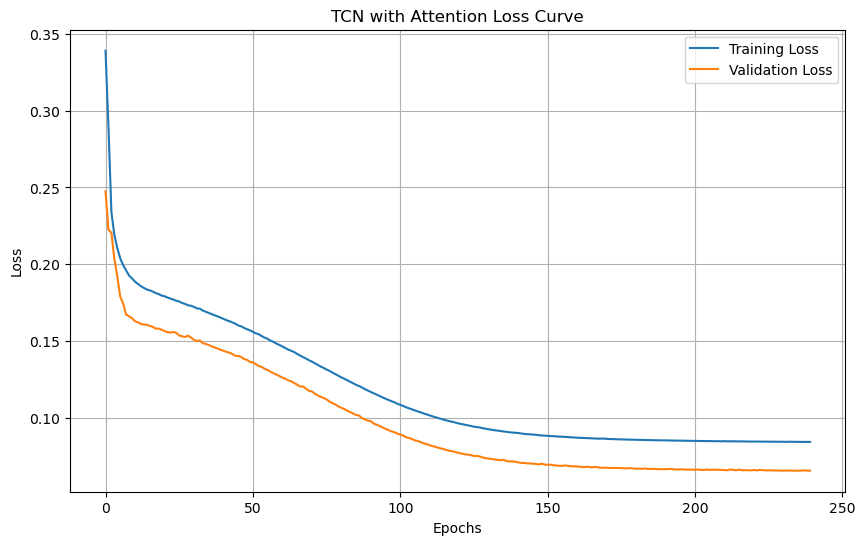

In [30]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import (
    Conv1D, Dense, Dropout, Flatten, Input, BatchNormalization, Activation, Add,
    MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Configuration for TCN parameters
tcn_config = {
    'filters': 128,
    'kernel_size': 3,
    'dropout_rate': 0.02,
    'l2_reg': 0.00013,
    'learning_rate': 0.00012,
    'batch_size': 32,
    'epochs': 500,
    'num_heads': 3
}

# TCN Block Function
def tcn_block(inputs, filters, kernel_size, dilation_rate, dropout_rate, l2_reg, activation):
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, kernel_regularizer=l2(l2_reg))(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dropout_rate)(x)

    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dropout_rate)(x)

    # Residual connection
    res = Conv1D(filters, 1, padding='same')(inputs)
    x = Add()([x, res])
    return x

# Multi-Head Attention Block
def mha_block(inputs, num_heads, key_dim, dropout_rate):
    query, key, value = inputs, inputs, inputs
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
        query=query, key=key, value=value
    )
    attention_output = Dropout(dropout_rate)(attention_output)
    
    # 1x1 convolution for residual connection
    res = Conv1D(inputs.shape[-1], 1, padding='same')(inputs)
    
    # Residual Connection and Layer Normalization
    out = LayerNormalization(epsilon=1e-6)(res + attention_output)
    return out

# Build the TCN model with Attention
def build_tcn_model_with_attention(input_shape, predict_days, config):
    inputs = Input(shape=input_shape)

    # TCN Blocks
    x = tcn_block(inputs, config['filters'], config['kernel_size'], 1, config['dropout_rate'], config['l2_reg'], activation='relu')
    x = tcn_block(x, config['filters'], config['kernel_size'], 2, config['dropout_rate'], config['l2_reg'], activation='relu')

    # Multi-Head Attention Block
    x = mha_block(x, num_heads=3, key_dim=32, dropout_rate=config['dropout_rate'])

    # Additional TCN Blocks
    x = tcn_block(x, config['filters'], config['kernel_size'], 4, config['dropout_rate'], config['l2_reg'], activation='relu')
    x = tcn_block(x, config['filters'], config['kernel_size'], 8, config['dropout_rate'], config['l2_reg'], activation='relu')

    # Flatten and Dense Layers
    x = Flatten()(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(config['l2_reg']))(x)
    output = Dense(predict_days, activation='relu')(x)

    model = Model(inputs=inputs, outputs=output)
    
    # Compile the Model
    optimizer = Adam(learning_rate=config['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Example Data Preparation (Replace with your data)
# Assume X_train, X_val, y_train, y_val are preprocessed
input_shape = (X_train.shape[1], X_train.shape[2])  # Time steps, features
predict_days = y_train.shape[1]

# Build the TCN model with Attention
model_tcn_attention = build_tcn_model_with_attention(input_shape, predict_days, tcn_config)

# Create model directory if it doesn't exist
model_dir = 'Trainedmodels'
os.makedirs(model_dir, exist_ok=True)

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history_tcn_attention = model_tcn_attention.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=tcn_config['epochs'],
    batch_size=tcn_config['batch_size'],
    callbacks=[early_stopping]
)

# Save the model
model_path = os.path.join(model_dir, 'tcn_model_with_attentionnew13.h5')
model_tcn_attention.save(model_path)
print(f"Model saved to: {model_path}")

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(history_tcn_attention.history['loss'], label='Training Loss')
plt.plot(history_tcn_attention.history['val_loss'], label='Validation Loss')
plt.title('TCN with Attention Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

21/21 [==============================] - 0s 3ms/step
Day 1:
  MAE  = 0.0691
  RMSE = 0.0919
  R²   = 0.9841
  NSE  = 0.9841
Day 2:
  MAE  = 0.0769
  RMSE = 0.0945
  R²   = 0.9832
  NSE  = 0.9832
Day 3:
  MAE  = 0.0761
  RMSE = 0.0983
  R²   = 0.9819
  NSE  = 0.9819
Day 4:
  MAE  = 0.0886
  RMSE = 0.1136
  R²   = 0.9758
  NSE  = 0.9758
Day 5:
  MAE  = 0.1073
  RMSE = 0.1386
  R²   = 0.9640
  NSE  = 0.9640
Day 6:
  MAE  = 0.0958
  RMSE = 0.1225
  R²   = 0.9719
  NSE  = 0.9719
Day 7:
  MAE  = 0.0957
  RMSE = 0.1235
  R²   = 0.9715
  NSE  = 0.9715

Summary Metrics Across All Days:
Average MAE  = 0.0871
Average RMSE = 0.1118
Average R²   = 0.9761
Average NSE  = 0.9761


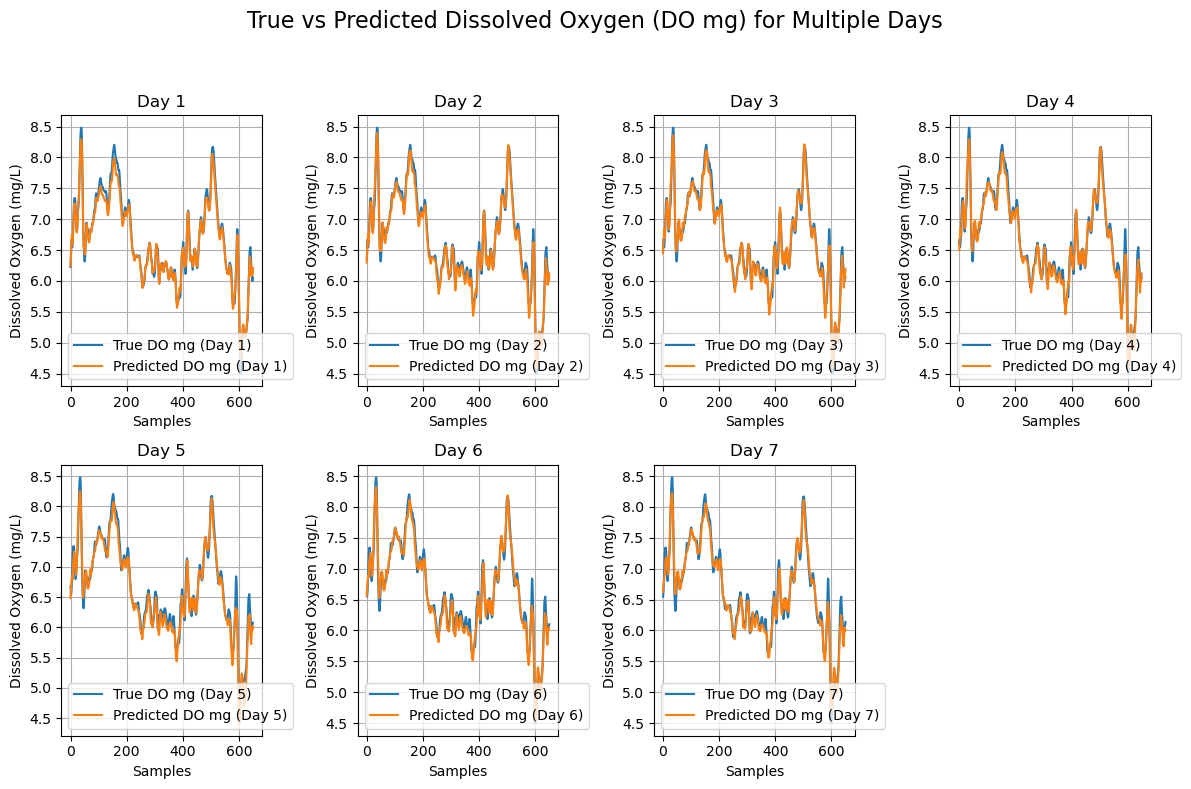

In [46]:
# Step 6: Load the trained TCN model with Multi-Head Attention
from tensorflow.keras.models import load_model
loaded_model = load_model('Trainedmodels/tcn_model_with_attention12.h5')

# Step 7: Predict using the loaded model
y_pred = loaded_model.predict(X_test)

# Step 8: Rescale predictions and test values back to the original scale
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create dummy arrays with the same shape as normalized_data
dummy_test = np.zeros((y_test.shape[0] * predict_days, normalized_data.shape[1]))
dummy_pred = np.zeros((y_pred.shape[0] * predict_days, normalized_data.shape[1]))

# Fill only the target column with y_test and y_pred values
dummy_test[:, target_col_idx] = y_test.flatten()
dummy_pred[:, target_col_idx] = y_pred.flatten()

# Perform inverse scaling
y_test_original = scaler.inverse_transform(dummy_test)[:, target_col_idx].reshape(-1, predict_days)
y_pred_original = scaler.inverse_transform(dummy_pred)[:, target_col_idx].reshape(-1, predict_days)

# Define a function for Nash-Sutcliffe Efficiency (NSE)
def nse(observed, predicted):
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (numerator / denominator)

# Step 9: Metrics for each prediction day
maes = []
rmses = []
mpes = []
r2s = []
nses = []

for day in range(predict_days):
    observed = y_test_original[:, day]
    predicted = y_pred_original[:, day]
    
    # Calculate metrics
    mae = mean_absolute_error(observed, predicted)
    rmse = np.sqrt(mean_squared_error(observed, predicted))
    mpe = np.mean((observed - predicted) / observed) * 100
    r2 = r2_score(observed, predicted)
    nse_val = nse(observed, predicted)
    
    # Append to respective lists
    maes.append(mae)
    rmses.append(rmse)
    mpes.append(mpe)
    r2s.append(r2)
    nses.append(nse_val)
    
    # Print metrics for the current day
    print(f"Day {day + 1}:")
    print(f"  MAE  = {mae:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  R²   = {r2:.4f}")
    print(f"  NSE  = {nse_val:.4f}")

# Optionally, summarize metrics across all days
print("\nSummary Metrics Across All Days:")
print(f"Average MAE  = {np.mean(maes):.4f}")
print(f"Average RMSE = {np.mean(rmses):.4f}")
print(f"Average R²   = {np.mean(r2s):.4f}")
print(f"Average NSE  = {np.mean(nses):.4f}")

# Step 10: Plot the results for all days (using rows and columns in a single figure)
import math

# Define the grid layout (e.g., 2 rows x 5 columns for 10 days)
rows = 2
cols = math.ceil(predict_days / rows)

# Create a figure for the subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for day in range(predict_days):
    ax = axes[day]
    ax.plot(y_test_original[:, day], label=f"True DO mg (Day {day + 1})",)
    ax.plot(y_pred_original[:, day], label=f"Predicted DO mg (Day {day + 1})")
    ax.legend()
    ax.set_title(f"Day {day + 1}")
    ax.set_xlabel("Samples")
    ax.set_ylabel("Dissolved Oxygen (mg/L)")
    ax.grid(True)

# Remove unused subplots if predict_days < rows * cols
for i in range(predict_days, rows * cols):
    fig.delaxes(axes[i])

# Adjust layout and show the figure
fig.suptitle("True vs Predicted Dissolved Oxygen (DO mg) for Multiple Days", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.94])  # Leave space for the main title
plt.show()


## LSTM MODEL ##

Epoch 1/50
33/33 [==============================] - 0s 4ms/step - loss: 0.1798 - mae: 0.2809 - val_loss: 0.0139 - val_mae: 0.0951
Epoch 2/50
33/33 [==============================] - 0s 2ms/step - loss: 0.0197 - mae: 0.1099 - val_loss: 0.0072 - val_mae: 0.0678
Epoch 3/50
33/33 [==============================] - 0s 2ms/step - loss: 0.0169 - mae: 0.1008 - val_loss: 0.0068 - val_mae: 0.0661
Epoch 4/50
33/33 [==============================] - 0s 2ms/step - loss: 0.0166 - mae: 0.0995 - val_loss: 0.0063 - val_mae: 0.0631
Epoch 5/50
33/33 [==============================] - 0s 2ms/step - loss: 0.0162 - mae: 0.0977 - val_loss: 0.0066 - val_mae: 0.0644
Epoch 6/50
33/33 [==============================] - 0s 2ms/step - loss: 0.0157 - mae: 0.0961 - val_loss: 0.0058 - val_mae: 0.0604
Epoch 7/50
33/33 [==============================] - 0s 2ms/step - loss: 0.0154 - mae: 0.0948 - val_loss: 0.0055 - val_mae: 0.0587
Epoch 8/50
33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - mae: 0.09

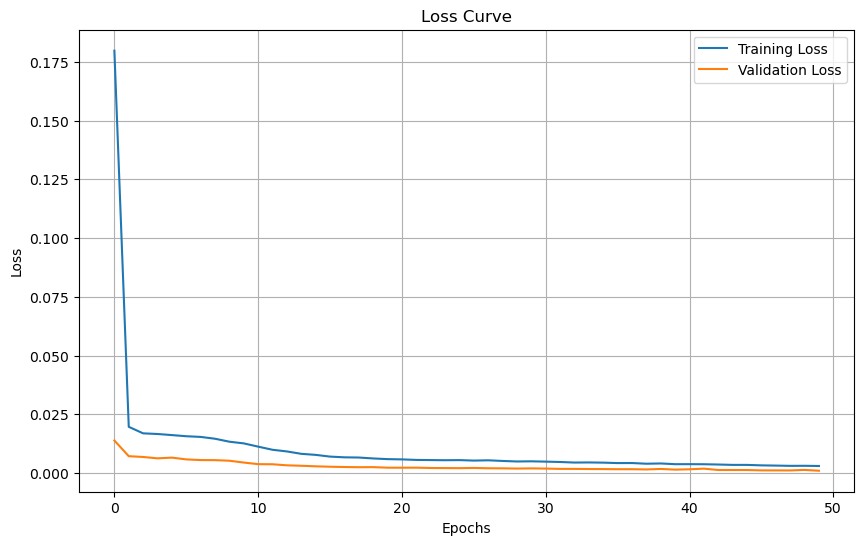

In [18]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Step 5: Build LSTM model with Dropout
model1 = Sequential([
    LSTM(64, activation='sigmoid', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.003),  # Dropout after LSTM layer
    Dense(32, activation='sigmoid'),
    Dropout(0.003),  # Dropout after Dense layer
    Dense(predict_days)  # Output for the next 10 days
])

# Define a custom learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model1.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
# Step 6: Train the model
history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64,callbacks=[early_stopping])

# Plotting the loss curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


21/21 [==============================] - 0s 770us/step
Day 1:
  MAE  = 0.0610
  RMSE = 0.0789
  R2  = 0.9883
Day 2:
  MAE  = 0.0808
  RMSE = 0.1125
  R2  = 0.9762
Day 3:
  MAE  = 0.1225
  RMSE = 0.1699
  R2  = 0.9458
Day 4:
  MAE  = 0.1299
  RMSE = 0.1827
  R2  = 0.9374
Day 5:
  MAE  = 0.1647
  RMSE = 0.2226
  R2  = 0.9071
Day 6:
  MAE  = 0.1867
  RMSE = 0.2518
  R2  = 0.8813
Day 7:
  MAE  = 0.2224
  RMSE = 0.2917
  R2  = 0.8409

Summary Metrics Across All Days:
Average MAE  = 0.1383
Average RMSE = 0.1872
Average R2  = 0.9253


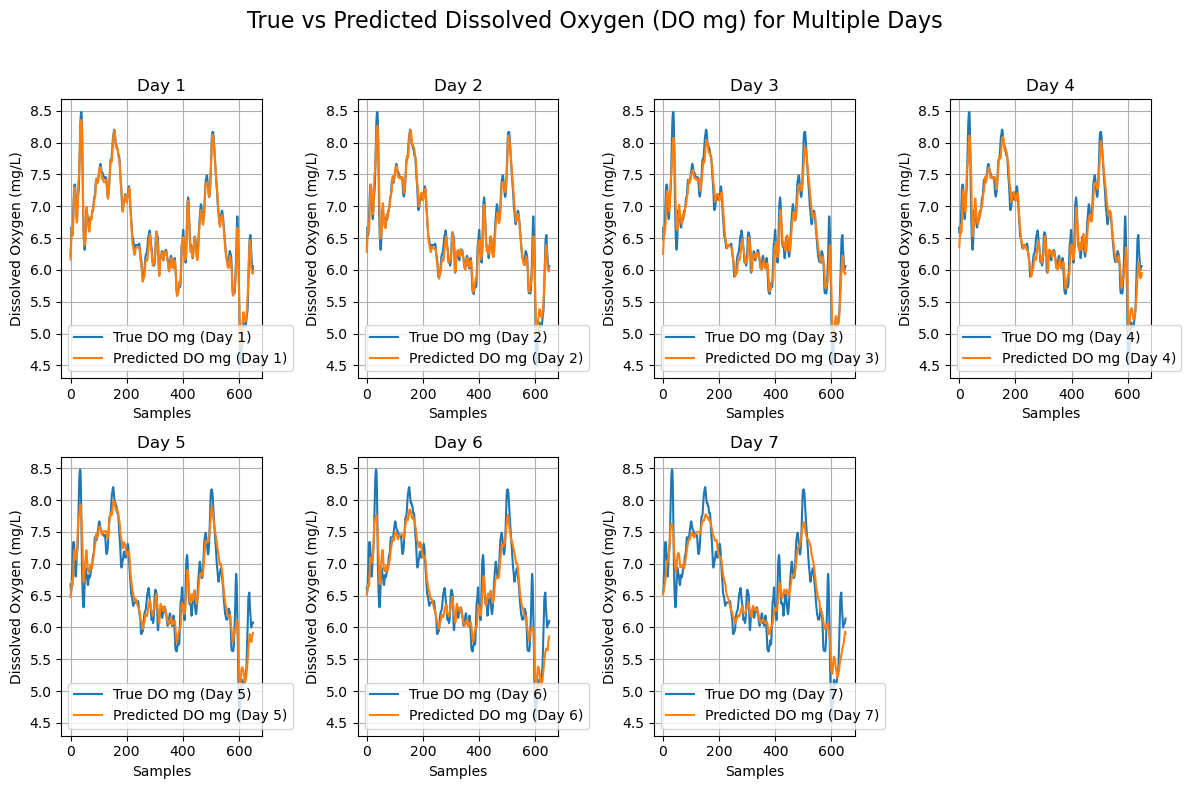

In [22]:
 # Step 7: Evaluate the model
y_pred = model1.predict(X_test)

# Step 8: Rescale predictions and test values back to the original scale
# Create dummy arrays with the same shape as normalized_data
dummy_test = np.zeros((y_test.shape[0] * predict_days, normalized_data.shape[1]))
dummy_pred = np.zeros((y_pred.shape[0] * predict_days, normalized_data.shape[1]))

# Fill only the target column with y_test and y_pred values
dummy_test[:, target_col_idx] = y_test.flatten()
dummy_pred[:, target_col_idx] = y_pred.flatten()

# Perform inverse scaling
y_test_original = scaler.inverse_transform(dummy_test)[:, target_col_idx].reshape(-1, predict_days)
y_pred_original = scaler.inverse_transform(dummy_pred)[:, target_col_idx].reshape(-1, predict_days)

from sklearn.metrics import r2_score

# Define a function for Nash-Sutcliffe Efficiency (NSE)
def nse(observed, predicted):
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (numerator / denominator)

# Step 9: Metrics for each prediction day
maes = []
rmses = []
nses = []

for day in range(predict_days):
    observed = y_test_original[:, day]
    predicted = y_pred_original[:, day]
    
    # Calculate metrics
    mae = mean_absolute_error(observed, predicted)
    rmse = np.sqrt(mean_squared_error(observed, predicted))
    nse_val = nse(observed, predicted)
    
    # Append to respective lists
    maes.append(mae)
    rmses.append(rmse)
    nses.append(nse_val)
    
    # Print metrics for the current day
    print(f"Day {day + 1}:")
    print(f"  MAE  = {mae:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  R2  = {nse_val:.4f}")

# Optionally, summarize metrics across all days
print("\nSummary Metrics Across All Days:")
print(f"Average MAE  = {np.mean(maes):.4f}")
print(f"Average RMSE = {np.mean(rmses):.4f}")
print(f"Average R2  = {np.mean(nses):.4f}")
# Step 10: Plot the results for all days (using rows and columns in a single figure)
import math

# Define the grid layout (e.g., 2 rows x 5 columns for 10 days)
rows = 2
cols = math.ceil(predict_days / rows)

# Create a figure for the subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for day in range(predict_days):
    ax = axes[day]
    ax.plot(y_test_original[:, day], label=f"True DO mg (Day {day + 1})")
    ax.plot(y_pred_original[:, day], label=f"Predicted DO mg (Day {day + 1})")
    ax.legend()
    ax.set_title(f"Day {day + 1}")
    ax.set_xlabel("Samples")
    ax.set_ylabel("Dissolved Oxygen (mg/L)")
    ax.grid(True)

# Remove unused subplots if predict_days < rows * cols
for i in range(predict_days, rows * cols):
    fig.delaxes(axes[i])

# Adjust layout and show the figure
fig.suptitle("True vs Predicted Dissolved Oxygen (DO mg) for Multiple Days", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
plt.show()

## GRU MODEL ##

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Configuration for the GRU model
config_gru = {
    'gru_units': 32,
    'dropout_rate': 0.02,  # Dropout rate (can be adjusted)
    'learning_rate': 0.04,  # Learning rate for Adam optimizer
    'epochs': 50,
    'batch_size': 64
}

# Step 5: Build GRU model with Dropout and Learning Rate
model_gru = Sequential([
    GRU(config_gru['gru_units'], activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(config_gru['dropout_rate']),  # Adding Dropout after GRU
    Dense(32, activation='sigmoid'),
    Dropout(config_gru['dropout_rate']),  # Adding Dropout after Dense layer
    Dense(predict_days)  # Output for the next `predict_days`
])

# Compile the model with a custom learning rate
optimizer = Adam(learning_rate=config_gru['learning_rate'])
model_gru.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Step 6: Train the GRU model
history_gru = model_gru.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=config_gru['epochs'], batch_size=config_gru['batch_size'])

# Extract loss values for plotting
train_loss_gru = history_gru.history['loss']
val_loss_gru = history_gru.history['val_loss']

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss_gru, label='Training Loss')
plt.plot(val_loss_gru, label='Validation Loss')
plt.title('GRU Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



NameError: name 'X_train' is not defined

21/21 [==============================] - 0s 529us/step


2025-01-06 15:46:17.982757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-06 15:46:17.983261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-06 15:46:17.983551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Day 1:
  MAE  = 0.0885
  RMSE = 0.1028
  R²   = 0.9801
  NSE  = 0.9801
Day 2:
  MAE  = 0.1042
  RMSE = 0.1225
  R²   = 0.9718
  NSE  = 0.9718
Day 3:
  MAE  = 0.1171
  RMSE = 0.1415
  R²   = 0.9624
  NSE  = 0.9624
Day 4:
  MAE  = 0.1337
  RMSE = 0.1632
  R²   = 0.9500
  NSE  = 0.9500
Day 5:
  MAE  = 0.1477
  RMSE = 0.1816
  R²   = 0.9382
  NSE  = 0.9382
Day 6:
  MAE  = 0.1681
  RMSE = 0.2041
  R²   = 0.9220
  NSE  = 0.9220
Day 7:
  MAE  = 0.1861
  RMSE = 0.2236
  R²   = 0.9064
  NSE  = 0.9064

Summary Metrics Across All Days:
Average MAE  = 0.1351
Average RMSE = 0.1628
Average R²   = 0.9473
Average NSE  = 0.9473


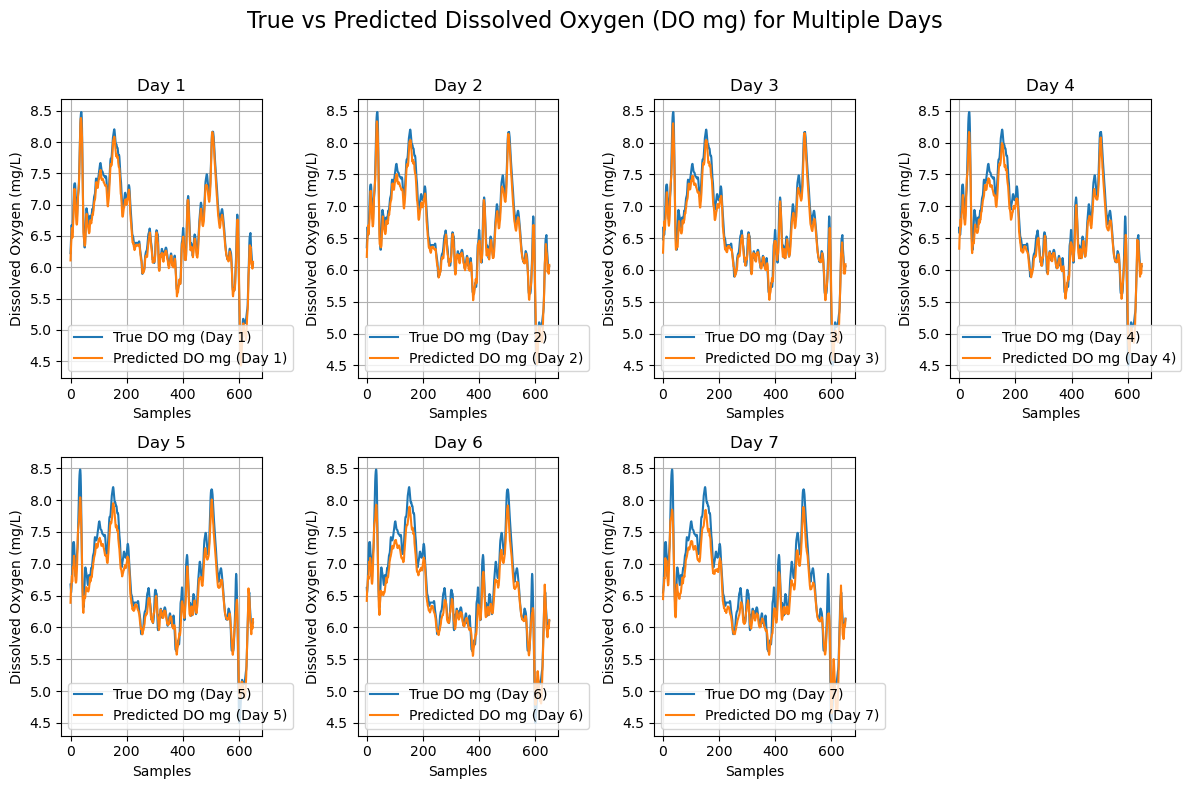

In [131]:
 # Step 7: Evaluate the model
y_pred = model_gru.predict(X_test)

# Step 8: Rescale predictions and test values back to the original scale
# Create dummy arrays with the same shape as normalized_data
dummy_test = np.zeros((y_test.shape[0] * predict_days, normalized_data.shape[1]))
dummy_pred = np.zeros((y_pred.shape[0] * predict_days, normalized_data.shape[1]))

# Fill only the target column with y_test and y_pred values
dummy_test[:, target_col_idx] = y_test.flatten()
dummy_pred[:, target_col_idx] = y_pred.flatten()

# Perform inverse scaling
y_test_original = scaler.inverse_transform(dummy_test)[:, target_col_idx].reshape(-1, predict_days)
y_pred_original = scaler.inverse_transform(dummy_pred)[:, target_col_idx].reshape(-1, predict_days)

from sklearn.metrics import r2_score

# Define a function for Nash-Sutcliffe Efficiency (NSE)
def nse(observed, predicted):
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (numerator / denominator)

# Step 9: Metrics for each prediction day
maes = []
rmses = []
mpes = []
r2s = []
nses = []

for day in range(predict_days):
    observed = y_test_original[:, day]
    predicted = y_pred_original[:, day]
    
    # Calculate metrics
    mae = mean_absolute_error(observed, predicted)
    rmse = np.sqrt(mean_squared_error(observed, predicted))
    mpe = np.mean((observed - predicted) / observed) * 100
    r2 = r2_score(observed, predicted)
    nse_val = nse(observed, predicted)
    
    # Append to respective lists
    maes.append(mae)
    rmses.append(rmse)
    r2s.append(r2)
    nses.append(nse_val)
    
    # Print metrics for the current day
    print(f"Day {day + 1}:")
    print(f"  MAE  = {mae:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  R²   = {r2:.4f}")
    print(f"  NSE  = {nse_val:.4f}")

# Optionally, summarize metrics across all days
print("\nSummary Metrics Across All Days:")
print(f"Average MAE  = {np.mean(maes):.4f}")
print(f"Average RMSE = {np.mean(rmses):.4f}")
print(f"Average R²   = {np.mean(r2s):.4f}")
print(f"Average NSE  = {np.mean(nses):.4f}")
# Step 10: Plot the results for all days (using rows and columns in a single figure)
import math

# Define the grid layout (e.g., 2 rows x 5 columns for 10 days)
rows = 2
cols = math.ceil(predict_days / rows)

# Create a figure for the subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for day in range(predict_days):
    ax = axes[day]
    ax.plot(y_test_original[:, day], label=f"True DO mg (Day {day + 1})")
    ax.plot(y_pred_original[:, day], label=f"Predicted DO mg (Day {day + 1})")
    ax.legend()
    ax.set_title(f"Day {day + 1}")
    ax.set_xlabel("Samples")
    ax.set_ylabel("Dissolved Oxygen (mg/L)")
    ax.grid(True)

# Remove unused subplots if predict_days < rows * cols
for i in range(predict_days, rows * cols):
    fig.delaxes(axes[i])

# Adjust layout and show the figure
fig.suptitle("True vs Predicted Dissolved Oxygen (DO mg) for Multiple Days", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
plt.show()

In [58]:
import pandas as pd
from sklearn.metrics import r2_score

# Define a function for Nash-Sutcliffe Efficiency (NSE)
def nse(observed, predicted):
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (numerator / denominator)

# Step 9: Metrics for each prediction day
metrics_data = []

for day in range(predict_days):
    observed = y_test_original[:, day]
    predicted = y_pred_original[:, day]
    
    # Calculate metrics
    mae = mean_absolute_error(observed, predicted)
    rmse = np.sqrt(mean_squared_error(observed, predicted))
    r2 = r2_score(observed, predicted)
    nse_val = nse(observed, predicted)
    
    # Append metrics to a list
    metrics_data.append({
        'Day': day + 1,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'NSE': nse_val
    })

# Convert metrics data to a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display metrics table
print("\nPerformance Metrics for Each Day:")
print(metrics_df)

# Optionally, save the table to a CSV file
metrics_df.to_csv("performance_metrics.csv", index=False)


Performance Metrics for Each Day:
   Day       MAE      RMSE        R²       NSE
0    1  0.053368  0.070254  0.990226  0.990226
1    2  0.068593  0.084831  0.985725  0.985725
2    3  0.062947  0.087223  0.984879  0.984879
3    4  0.075354  0.097462  0.981084  0.981084
4    5  0.073703  0.089032  0.984186  0.984186
5    6  0.075619  0.091860  0.983138  0.983138
6    7  0.069756  0.083239  0.986134  0.986134
7    8  0.078684  0.100781  0.979649  0.979649
8    9  0.097052  0.131556  0.965286  0.965286
9   10  0.112687  0.152512  0.953311  0.953311


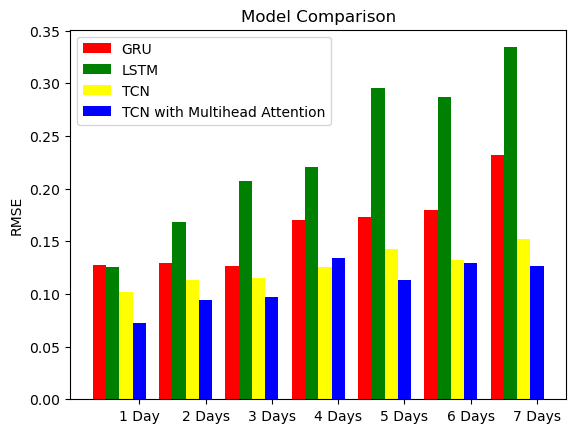

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the chart
rmse_values = {
    "GRU": [0.1271, 0.1292, 0.1265, 0.1704, 0.1731,0.1794,0.2316],
    "LSTM": [0.1255, 0.1685, 0.2069, 0.2207, 0.2953,0.2873,0.3341],
    "TCN": [0.1021, 0.1132, 0.1155, 0.1256, 0.1425,0.1323,0.1520],
    "TCN with Multihead Attention": [0.0722, 0.0944, 0.0975, 0.1342, 0.1129,0.1292,0.1266]
}

# Labels for the x-axis
labels = ['1 Day', '2 Days', '3 Days', '4 Days', '5 Days','6 Days','7 Days']

# Colors for each model
colors = ['red', 'green', 'yellow', 'blue']

# Create the bar chart
fig, ax = plt.subplots()
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

# Create bars for each model
for i, model in enumerate(rmse_values):
    ax.bar(x + i*width, rmse_values[model], width, label=model, color=colors[i])

# Set x-axis labels
ax.set_xticks(x + width*3)
ax.set_xticklabels(labels)

# Set y-axis label
ax.set_ylabel('RMSE')

# Set title (optional)
ax.set_title('Model Comparison')

# Add legend
ax.legend()

# Show the plot
plt.show()

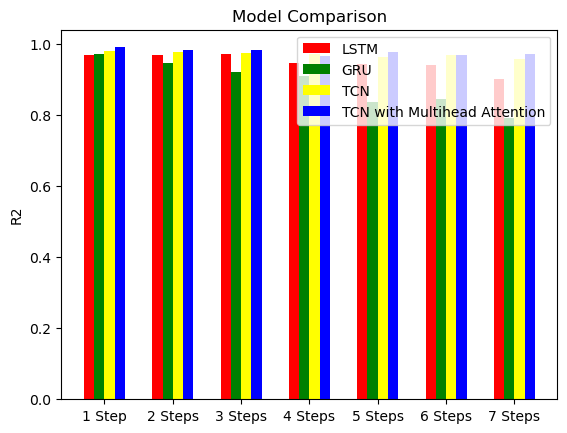

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the chart
rmse_values = {
    "LSTM": [0.9696,0.9686,0.9699,0.9455,0.9438,0.9398,0.8997],
    "GRU": [0.9704,0.9466,0.9196,0.9086,0.8366,0.8455,0.7912],
    "TCN": [0.9804,0.9759,0.9750,0.9704,0.9619,0.9672,0.9568],
    "TCN with Multihead Attention": [0.9902,0.9832,0.9822,0.9662,0.9761,0.9688,0.9700]
}

# Labels for the x-axis
labels = ['1 Step', '2 Steps', '3 Steps', '4 Steps', '5 Steps','6 Steps','7 Steps']

# Colors for each model
colors = ['red', 'green', 'yellow', 'blue']

# Create the bar chart
fig, ax = plt.subplots()
x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

# Create bars for each model
for i, model in enumerate(rmse_values):
    ax.bar(x + i*width, rmse_values[model], width, label=model, color=colors[i])

# Set x-axis labels
ax.set_xticks(x + width*1.5)
ax.set_xticklabels(labels)

# Set y-axis label
ax.set_ylabel('R2')

# Set title (optional)
ax.set_title('Model Comparison')

# Add legend
ax.legend()
# Show the plot
plt.show()

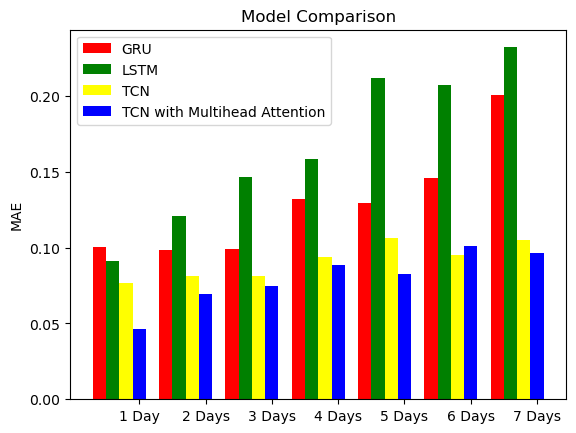

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the chart
rmse_values = {
    "GRU": [0.1003,
0.0987,
0.0989,
0.1322,
0.1297,
0.1457,
0.2006

],
    "LSTM": [0.0910,
0.1208,
0.1464,
0.1586,
0.2117,
0.2076,
0.2322
],
    "TCN": [0.0767,
0.0816,
0.0814,
0.0941,
0.1066,
0.0951,
0.1051

],
    "TCN with Multihead Attention": [0.0466,
0.0694,
0.0750,
0.0887,
0.0829,
0.1008,
0.0966

]
}

# Labels for the x-axis
labels = ['1 Day', '2 Days', '3 Days', '4 Days', '5 Days','6 Days','7 Days']


# Colors for each model
colors = ['red', 'green', 'yellow', 'blue']

# Create the bar chart
fig, ax = plt.subplots()
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

# Create bars for each model
for i, model in enumerate(rmse_values):
    ax.bar(x + i*width, rmse_values[model], width, label=model, color=colors[i])

# Set x-axis labels
ax.set_xticks(x + width*3)
ax.set_xticklabels(labels)

# Set y-axis label
ax.set_ylabel('MAE')

# Set title (optional)
ax.set_title('Model Comparison')

# Add legend
ax.legend()

# Show the plot
plt.show()


21/21 [==============================] - 0s 3ms/step
Day 1:
  MAE  = 0.0691
  RMSE = 0.0919
  R²   = 0.9841
  NSE  = 0.9841
Day 2:
  MAE  = 0.0769
  RMSE = 0.0945
  R²   = 0.9832
  NSE  = 0.9832
Day 3:
  MAE  = 0.0761
  RMSE = 0.0983
  R²   = 0.9819
  NSE  = 0.9819
Day 4:
  MAE  = 0.0886
  RMSE = 0.1136
  R²   = 0.9758
  NSE  = 0.9758
Day 5:
  MAE  = 0.1073
  RMSE = 0.1386
  R²   = 0.9640
  NSE  = 0.9640
Day 6:
  MAE  = 0.0958
  RMSE = 0.1225
  R²   = 0.9719
  NSE  = 0.9719
Day 7:
  MAE  = 0.0957
  RMSE = 0.1235
  R²   = 0.9715
  NSE  = 0.9715

Summary Metrics Across All Days:
Average MAE  = 0.0871
Average RMSE = 0.1118
Average R²   = 0.9761
Average NSE  = 0.9761


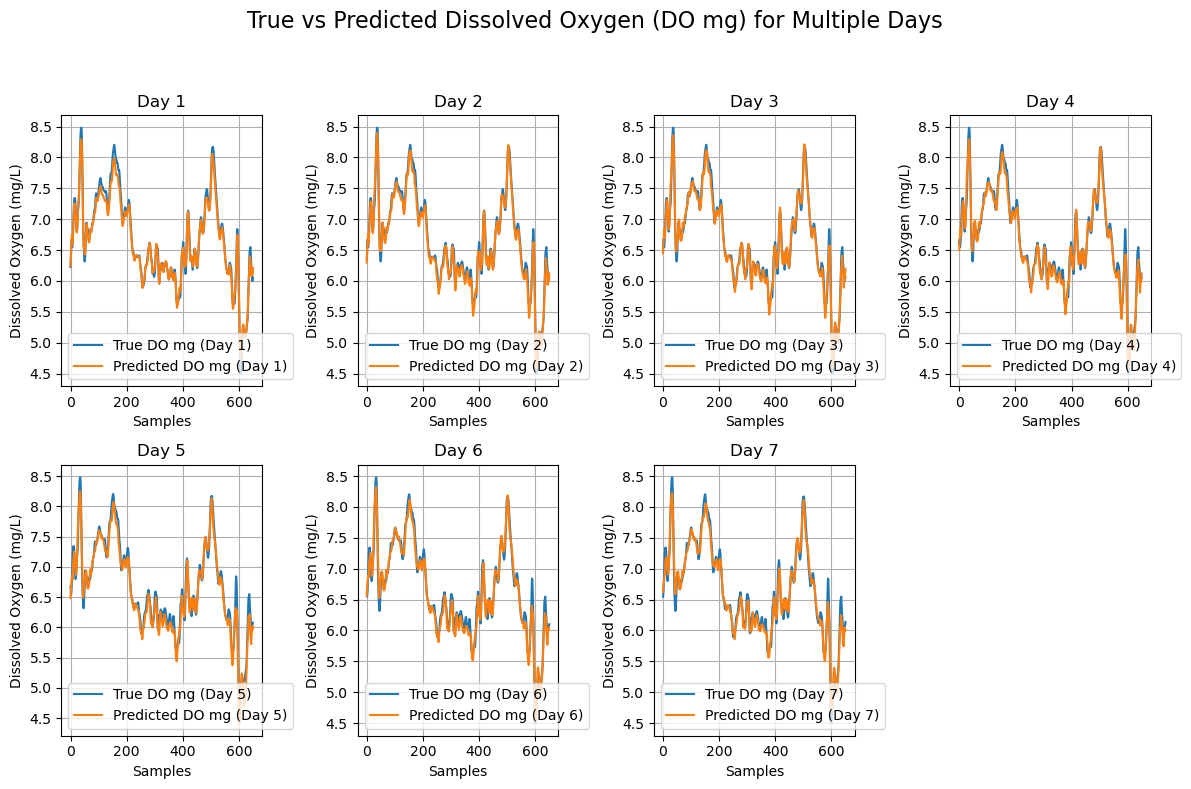

In [25]:
# Step 6: Load the trained TCN model with Multi-Head Attention
from tensorflow.keras.models import load_model
loaded_model = load_model('Trainedmodels/tcn_model_with_attention12.h5')

# Step 7: Predict using the loaded model
y_pred = loaded_model.predict(X_test)

# Step 8: Rescale predictions and test values back to the original scale
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create dummy arrays with the same shape as normalized_data
dummy_test = np.zeros((y_test.shape[0] * predict_days, normalized_data.shape[1]))
dummy_pred = np.zeros((y_pred.shape[0] * predict_days, normalized_data.shape[1]))

# Fill only the target column with y_test and y_pred values
dummy_test[:, target_col_idx] = y_test.flatten()
dummy_pred[:, target_col_idx] = y_pred.flatten()

# Perform inverse scaling
y_test_original = scaler.inverse_transform(dummy_test)[:, target_col_idx].reshape(-1, predict_days)
y_pred_original = scaler.inverse_transform(dummy_pred)[:, target_col_idx].reshape(-1, predict_days)

# Define a function for Nash-Sutcliffe Efficiency (NSE)
def nse(observed, predicted):
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (numerator / denominator)

# Step 9: Metrics for each prediction day
maes = []
rmses = []
mpes = []
r2s = []
nses = []

for day in range(predict_days):
    observed = y_test_original[:, day]
    predicted = y_pred_original[:, day]
    
    # Calculate metrics
    mae = mean_absolute_error(observed, predicted)
    rmse = np.sqrt(mean_squared_error(observed, predicted))
    mpe = np.mean((observed - predicted) / observed) * 100
    r2 = r2_score(observed, predicted)
    nse_val = nse(observed, predicted)
    
    # Append to respective lists
    maes.append(mae)
    rmses.append(rmse)
    mpes.append(mpe)
    r2s.append(r2)
    nses.append(nse_val)
    
    # Print metrics for the current day
    print(f"Day {day + 1}:")
    print(f"  MAE  = {mae:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  R²   = {r2:.4f}")
    print(f"  NSE  = {nse_val:.4f}")

# Optionally, summarize metrics across all days
print("\nSummary Metrics Across All Days:")
print(f"Average MAE  = {np.mean(maes):.4f}")
print(f"Average RMSE = {np.mean(rmses):.4f}")
print(f"Average R²   = {np.mean(r2s):.4f}")
print(f"Average NSE  = {np.mean(nses):.4f}")

# Step 10: Plot the results for all days (using rows and columns in a single figure)
import math

# Define the grid layout (e.g., 2 rows x 5 columns for 10 days)
rows = 2
cols = math.ceil(predict_days / rows)

# Create a figure for the subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for day in range(predict_days):
    ax = axes[day]
    ax.plot(y_test_original[:, day], label=f"True DO mg (Day {day + 1})",)
    ax.plot(y_pred_original[:, day], label=f"Predicted DO mg (Day {day + 1})")
    ax.legend()
    ax.set_title(f"Day {day + 1}")
    ax.set_xlabel("Samples")
    ax.set_ylabel("Dissolved Oxygen (mg/L)")
    ax.grid(True)

# Remove unused subplots if predict_days < rows * cols
for i in range(predict_days, rows * cols):
    fig.delaxes(axes[i])

# Adjust layout and show the figure
fig.suptitle("True vs Predicted Dissolved Oxygen (DO mg) for Multiple Days", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.94])  # Leave space for the main title
plt.show()

21/21 [==============================] - 0s 4ms/step
Day 1:
  MAE  = 0.0592
  RMSE = 0.0837
  R²   = 0.9868
  NSE  = 0.9868
Day 2:
  MAE  = 0.0677
  RMSE = 0.0911
  R²   = 0.9844
  NSE  = 0.9844
Day 3:
  MAE  = 0.0763
  RMSE = 0.1070
  R²   = 0.9785
  NSE  = 0.9785
Day 4:
  MAE  = 0.0848
  RMSE = 0.1194
  R²   = 0.9732
  NSE  = 0.9732
Day 5:
  MAE  = 0.0834
  RMSE = 0.1098
  R²   = 0.9774
  NSE  = 0.9774
Day 6:
  MAE  = 0.0873
  RMSE = 0.1202
  R²   = 0.9729
  NSE  = 0.9729
Day 7:
  MAE  = 0.0881
  RMSE = 0.1156
  R²   = 0.9750
  NSE  = 0.9750

Summary Metrics Across All Days:
Average MAE  = 0.0781
Average RMSE = 0.1067
Average R²   = 0.9783
Average NSE  = 0.9783


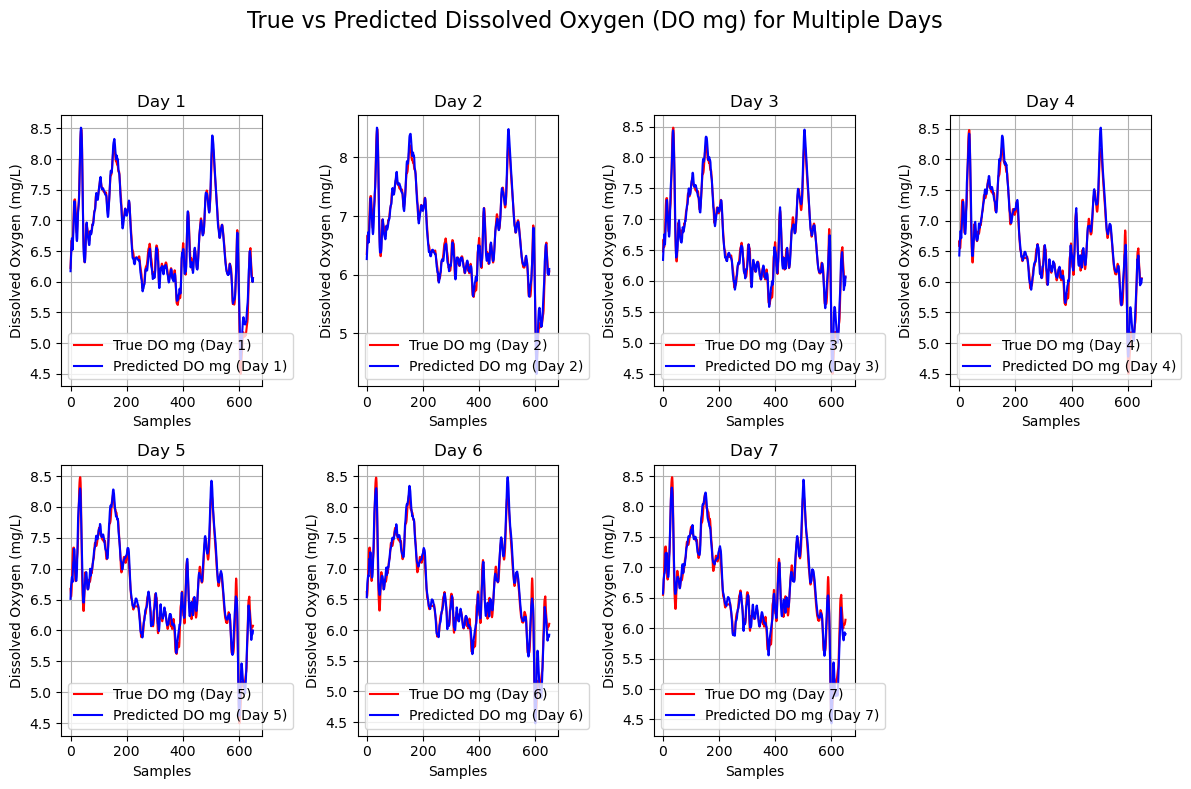

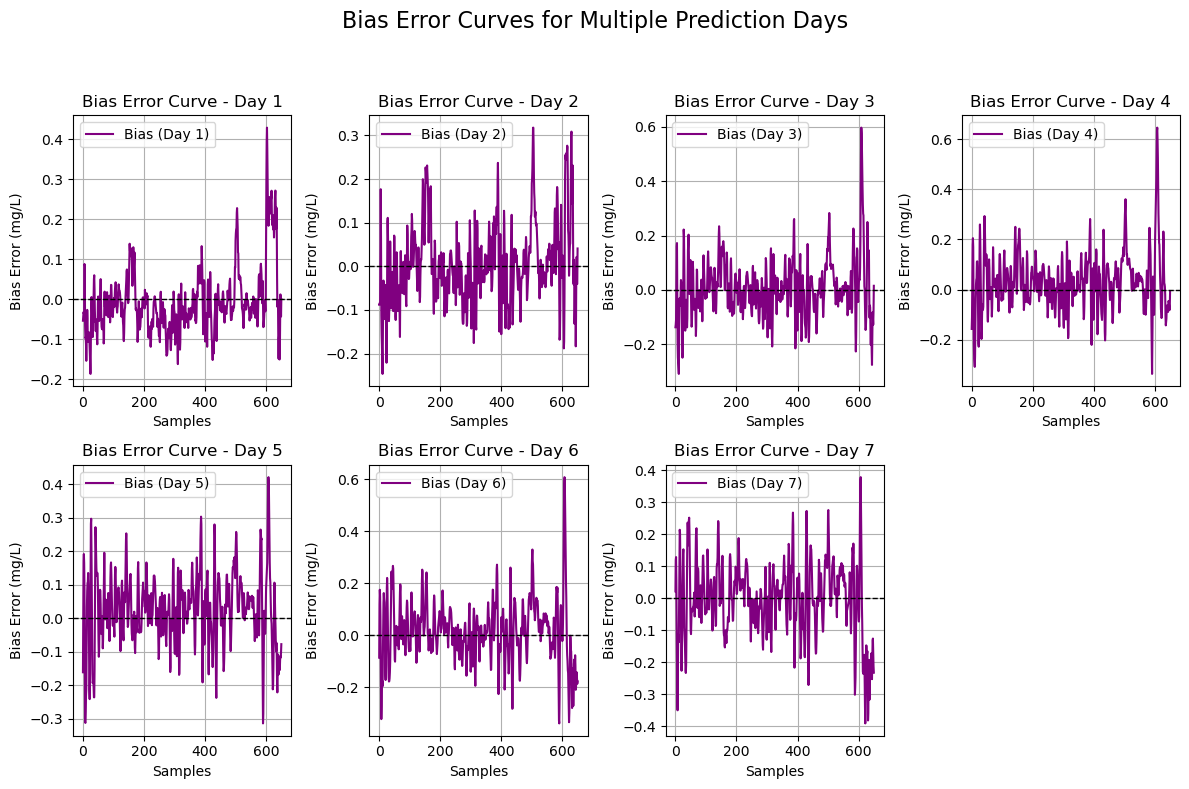

In [32]:
# Later, load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('Trainedmodels/tcn_model12.h5')
# Step 7: Evaluate the model
y_pred = loaded_model.predict(X_test)

# Step 8: Rescale predictions and test values back to the original scale
# Create dummy arrays with the same shape as normalized_data
dummy_test = np.zeros((y_test.shape[0] * predict_days, normalized_data.shape[1]))
dummy_pred = np.zeros((y_pred.shape[0] * predict_days, normalized_data.shape[1]))

# Fill only the target column with y_test and y_pred values
dummy_test[:, target_col_idx] = y_test.flatten()
dummy_pred[:, target_col_idx] = y_pred.flatten()

# Perform inverse scaling
y_test_original = scaler.inverse_transform(dummy_test)[:, target_col_idx].reshape(-1, predict_days)
y_pred_original = scaler.inverse_transform(dummy_pred)[:, target_col_idx].reshape(-1, predict_days)

from sklearn.metrics import r2_score

# Define a function for Nash-Sutcliffe Efficiency (NSE)
def nse(observed, predicted):
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (numerator / denominator)

# Step 9: Metrics for each prediction day
maes = []
rmses = []
mpes = []
r2s = []
nses = []

for day in range(predict_days):
    observed = y_test_original[:, day]
    predicted = y_pred_original[:, day]
    
    # Calculate metrics
    mae = mean_absolute_error(observed, predicted)
    rmse = np.sqrt(mean_squared_error(observed, predicted))
    mpe = np.mean((observed - predicted) / observed) * 100
    r2 = r2_score(observed, predicted)
    nse_val = nse(observed, predicted)
    
    # Append to respective lists
    maes.append(mae)
    rmses.append(rmse)
    mpes.append(mpe)
    r2s.append(r2)
    nses.append(nse_val)
    
    # Print metrics for the current day
    print(f"Day {day + 1}:")
    print(f"  MAE  = {mae:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  R²   = {r2:.4f}")
    print(f"  NSE  = {nse_val:.4f}")

# Optionally, summarize metrics across all days
print("\nSummary Metrics Across All Days:")
print(f"Average MAE  = {np.mean(maes):.4f}")
print(f"Average RMSE = {np.mean(rmses):.4f}")
print(f"Average R²   = {np.mean(r2s):.4f}")
print(f"Average NSE  = {np.mean(nses):.4f}")
# Step 10: Plot the results for all days (using rows and columns in a single figure)
import math

# Define the grid layout (e.g., 2 rows x 5 columns for 10 days)
rows = 2
cols = math.ceil(predict_days / rows)

# Create a figure for the subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for day in range(predict_days):
    ax = axes[day]
    ax.plot(y_test_original[:, day], label=f"True DO mg (Day {day + 1})",color='red')
    ax.plot(y_pred_original[:, day], label=f"Predicted DO mg (Day {day + 1})", color='blue')
    ax.legend()
    ax.set_title(f"Day {day + 1}")
    ax.set_xlabel("Samples")
    ax.set_ylabel("Dissolved Oxygen (mg/L)")
    ax.grid(True)

# Remove unused subplots if predict_days < rows * cols
for i in range(predict_days, rows * cols):
    fig.delaxes(axes[i])

# Adjust layout and show the figure
fig.suptitle("True vs Predicted Dissolved Oxygen (DO mg) for Multiple Days", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.94])  # Leave space for the main title
plt.show()
import numpy as np
import matplotlib.pyplot as plt
import math

# Compute bias for each day (Predicted - True)
bias_values = y_pred_original - y_test_original

# Define grid layout for bias plots (same as the previous layout)
rows = 2
cols = math.ceil(predict_days / rows)

# Create a figure for bias subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten()  # Flatten for easy indexing

for day in range(predict_days):
    ax = axes[day]
    ax.plot(bias_values[:, day], label=f"Bias (Day {day + 1})", color='purple')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Zero bias reference line
    ax.legend()
    ax.set_title(f"Bias Error Curve - Day {day + 1}")
    ax.set_xlabel("Samples")
    ax.set_ylabel("Bias Error (mg/L)")
    ax.grid(True)

# Remove unused subplots if predict_days < rows * cols
for i in range(predict_days, rows * cols):
    fig.delaxes(axes[i])

# Adjust layout and display the plot
fig.suptitle("Bias Error Curves for Multiple Prediction Days", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.94])  # Leave space for the main title
plt.show()
